---
---
# Sequnce Modeling: Recurrent and Recursive Nets
---
---

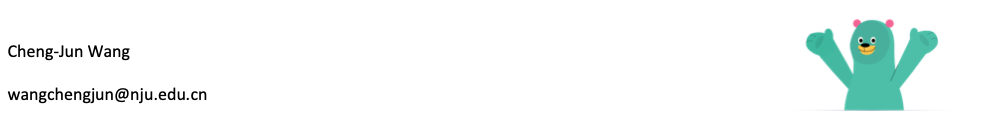


**Recurrent neural networks**, or RNNs (Rumelhart et al., 1986a), are a family of neural networks for processing sequential data. 

Much as a convolutional network is a neural network that is specialized for processing a grid of values $X$ such as an image, a recurrent neural network is a neural network that is specialized for processing a sequence of values $x^{(1)}$, . . . , $x^{(τ)}$. 


Most recurrent networks can also process sequences of *variable length*.

**RNN Applications: series of data**

- Time series prediction
- Language modeling (text generation)
- Text sentiment analysis 
- Named entity recognition
- Translation
- Speech recognition 
- Anomaly detection in time series 
- Music composition
- ...


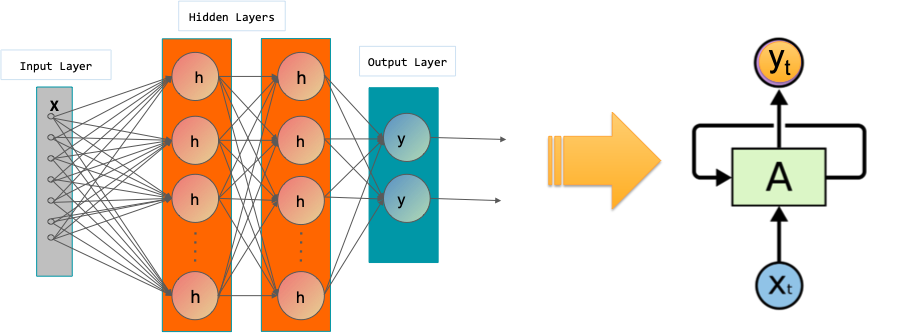

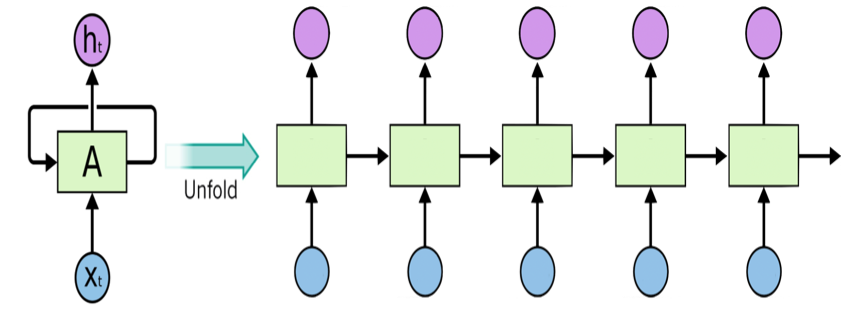

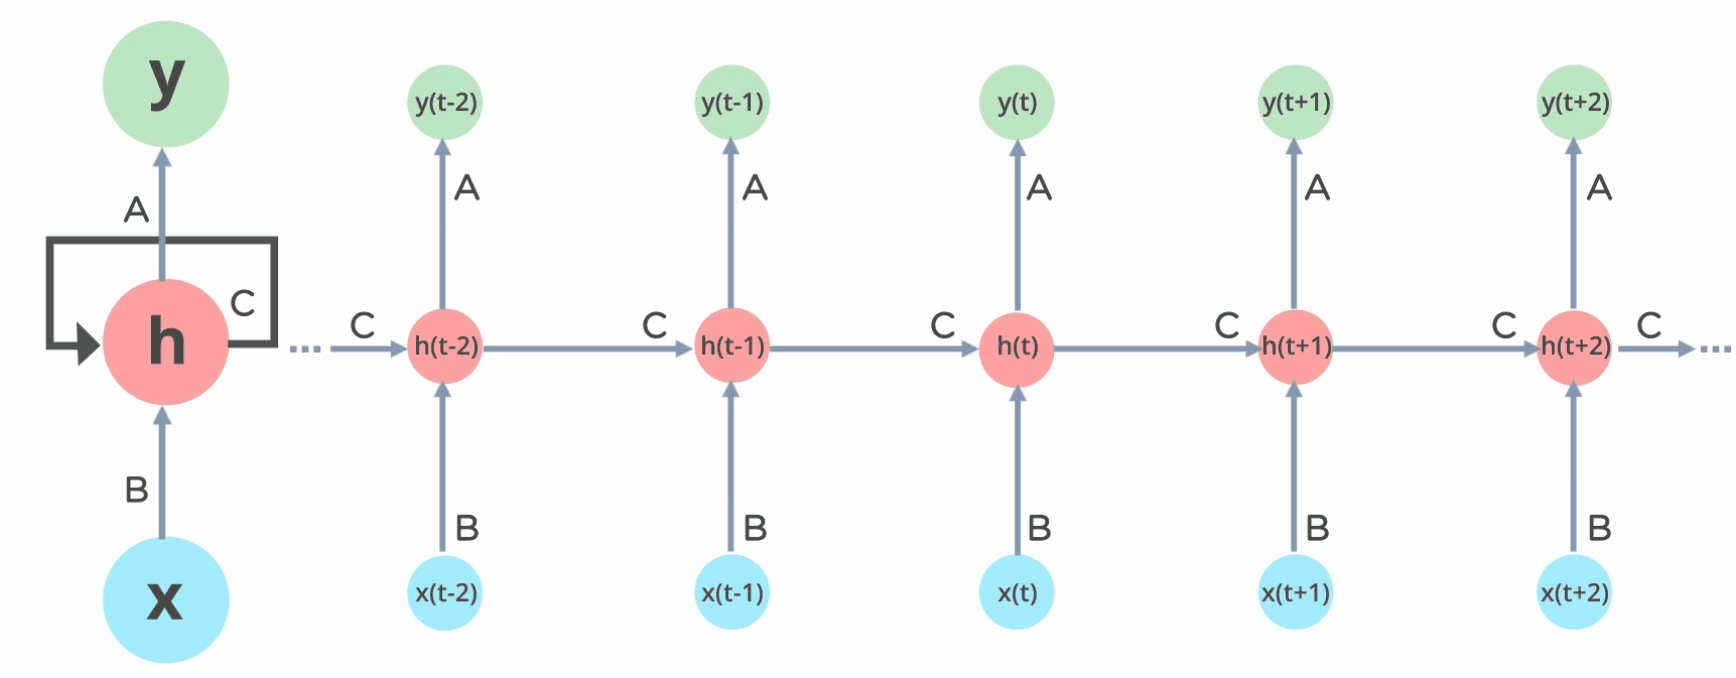

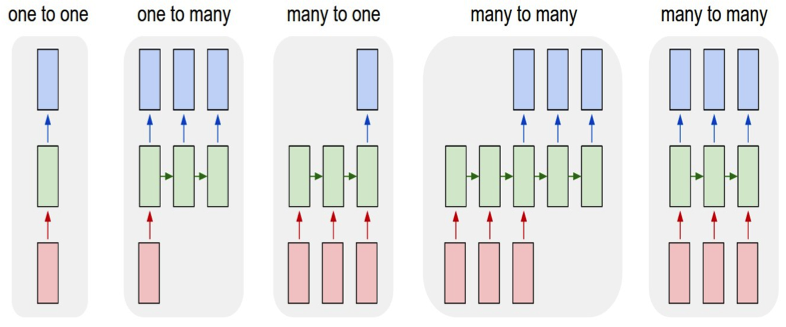

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

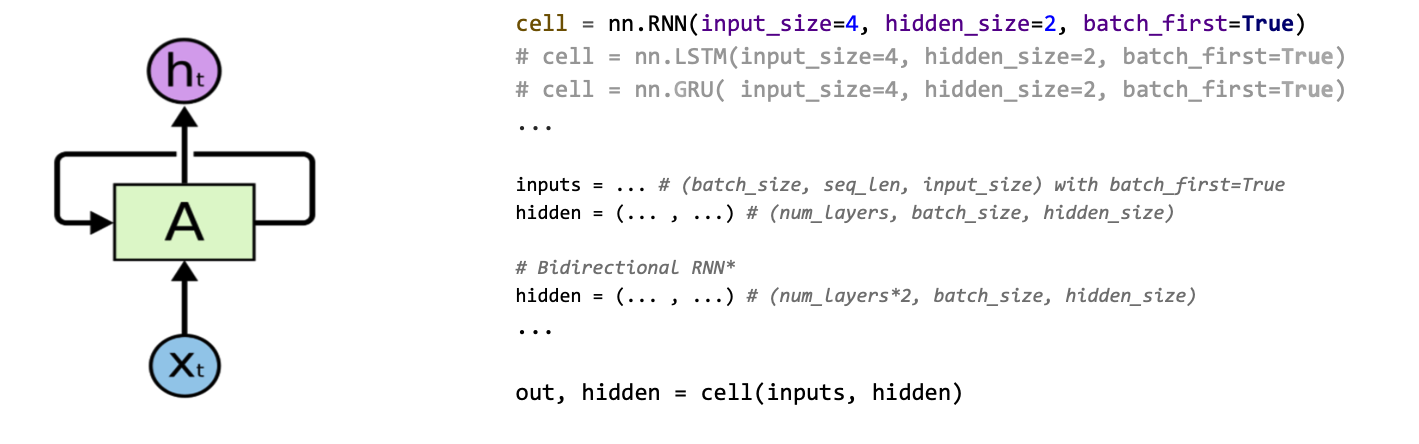

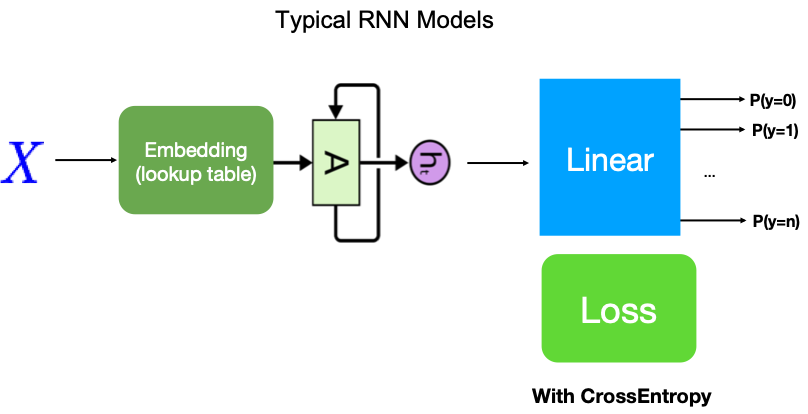

## RNN in a Nutshell

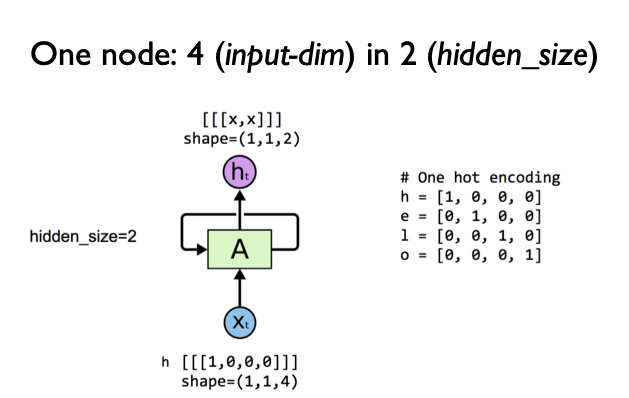

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# One hot encoding for each char in 'hello'
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]

In [2]:
# One cell RNN input_dim (4) -> output_dim (2). sequence: 5
cell = nn.RNN(input_size=4, hidden_size=2, batch_first=True)

# (num_layers * num_directions, batch, hidden_size) whether batch_first=True or False
hidden = Variable(torch.randn(1, 1, 2))

In [3]:
# Propagate input through RNN
# Input: (batch, seq_len, input_size) when batch_first=True
inputs = Variable(torch.Tensor([h, e, l, l, o]))
# Propagate input through RNN
# Input: (batch, seq_len, input_size) when batch_first=True
inputs = inputs.view(1, 5, -1)
out, hidden = cell(inputs, hidden)
print("sequence input size", inputs.size(), "out size", out.size())

sequence input size torch.Size([1, 5, 4]) out size torch.Size([1, 5, 2])


In [9]:
# One cell RNN input_dim (4) -> output_dim (2). sequence: 5, batch 3
# 3 batches 'hello', 'eolll', 'lleel'
# rank = (3, 5, 4)
inputs = Variable(torch.Tensor([[h, e, l, l, o],
                                [e, o, l, l, l],
                                [l, l, e, e, l]]))

# hidden : (num_layers * num_directions, batch, hidden_size) whether batch_first=True or False
hidden = Variable(torch.randn(1, 3, 2))

# Propagate input through RNN
# Input: (batch, seq_len, input_size) when batch_first=True
# B x S x I
out, hidden = cell(inputs, hidden)
print("batch input size", inputs.size(), "out size", out.size())

batch input size torch.Size([3, 5, 4]) out size torch.Size([3, 5, 2])


In [10]:
inputs

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]])

In [11]:
hidden

tensor([[[0.4196, 0.8705],
         [0.3543, 0.2878],
         [0.5785, 0.2704]]], grad_fn=<StackBackward>)

In [12]:
out

tensor([[[-0.4925,  0.2061],
         [-0.0136,  0.5975],
         [ 0.5275,  0.0605],
         [ 0.1702,  0.2726],
         [ 0.4196,  0.8705]],

        [[-0.6582,  0.6415],
         [ 0.6723,  0.6984],
         [ 0.4791,  0.5166],
         [ 0.4216,  0.3644],
         [ 0.3543,  0.2878]],

        [[ 0.4837, -0.5505],
         [-0.1786,  0.0664],
         [-0.1517,  0.7002],
         [ 0.2128,  0.7917],
         [ 0.5785,  0.2704]]], grad_fn=<TransposeBackward1>)

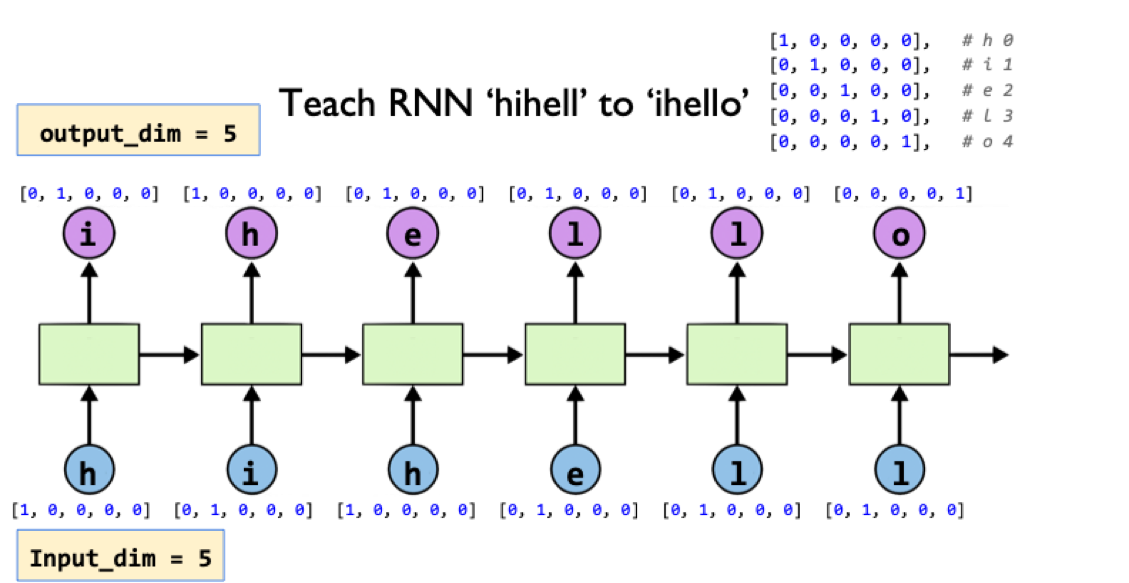

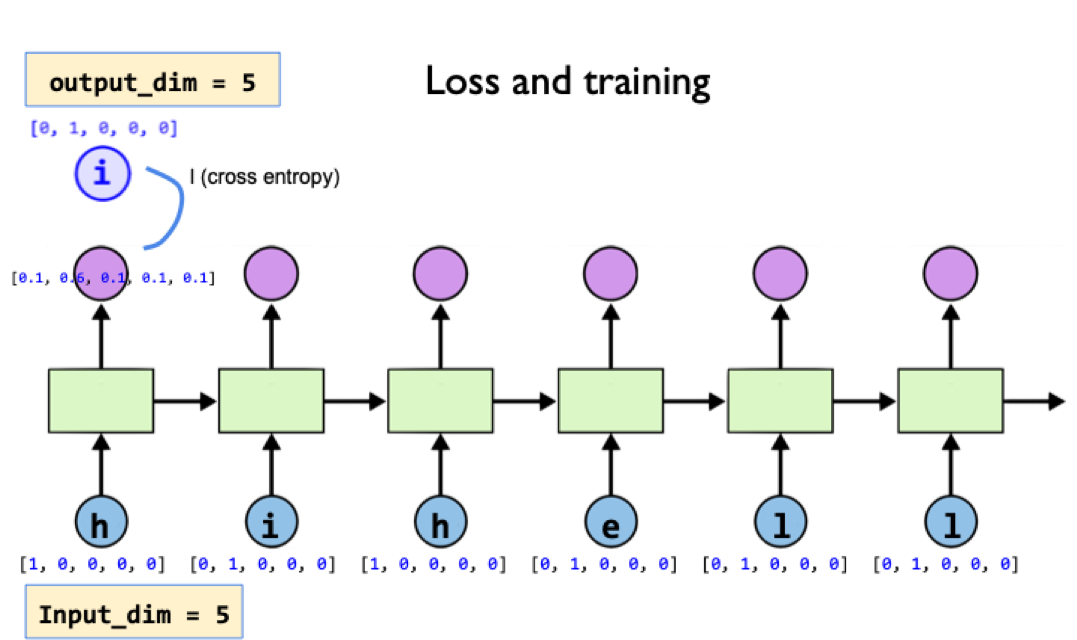

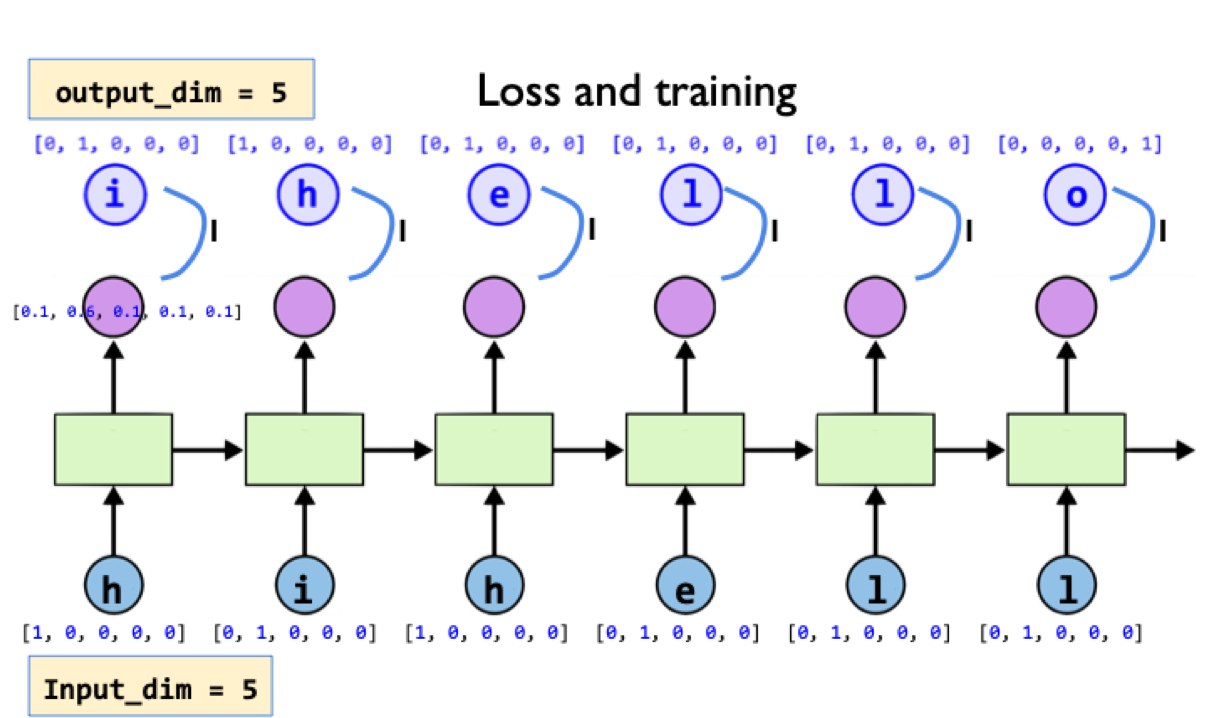

In [13]:
import sys
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(777)  # reproducibility
#            0    1    2    3    4
idx2char = ['h', 'i', 'e', 'l', 'o']

# Teach hihell -> ihello
x_data = [0, 1, 0, 2, 3, 3]   # hihell
one_hot_lookup = [[1, 0, 0, 0, 0],  # 0
                  [0, 1, 0, 0, 0],  # 1
                  [0, 0, 1, 0, 0],  # 2
                  [0, 0, 0, 1, 0],  # 3
                  [0, 0, 0, 0, 1]]  # 4

y_data = [1, 0, 2, 3, 3, 4]    # ihello
x_one_hot = [one_hot_lookup[x] for x in x_data]

In [15]:
# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.Tensor(x_one_hot))
labels = Variable(torch.LongTensor(y_data))

num_classes = 5
input_size = 5  # one-hot size
hidden_size = 5  # output from the RNN. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 1  #Note: One by one
num_layers = 1  # one-layer rnn
labels

tensor([1, 0, 2, 3, 3, 4])

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size, batch_first=True)
    def forward(self, hidden, x):
        # Reshape input (batch first)
        x = x.view(batch_size, sequence_length, input_size)
        # Propagate input through RNN
        # Input: (batch, seq_len, input_size)
        # hidden: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.rnn(x, hidden)
        return hidden, out.view(-1, num_classes)
    def init_hidden(self):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))

In [17]:
# Instantiate RNN model
model = Model()
print(model)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Model(
  (rnn): RNN(5, 5, batch_first=True)
)


In [18]:
# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    loss = 0
    hidden = model.init_hidden()

    sys.stdout.write("predicted string: ")
    for input, label in zip(inputs, labels):
        # print(input.size(), label.size())
        hidden, output = model(hidden, input)
        val, idx = output.max(1)
        sys.stdout.write(idx2char[idx.data[0]])
        #label_one_hot = one_hot_lookup[label]
        loss += criterion(output, label.view(-1))

    print(", epoch: %d, loss: %1.3f" % (epoch + 1, loss.item()))

    loss.backward()
    optimizer.step()

print("Learning finished!")

predicted string: llllll, epoch: 1, loss: 10.155
predicted string: llllll, epoch: 2, loss: 9.137
predicted string: llllll, epoch: 3, loss: 8.355
predicted string: llllll, epoch: 4, loss: 7.577
predicted string: llllll, epoch: 5, loss: 6.876
predicted string: lhelll, epoch: 6, loss: 6.327
predicted string: ihelll, epoch: 7, loss: 6.014
predicted string: ihelll, epoch: 8, loss: 5.787
predicted string: ihelll, epoch: 9, loss: 5.477
predicted string: ihelll, epoch: 10, loss: 5.274
predicted string: ihelll, epoch: 11, loss: 5.041
predicted string: ihello, epoch: 12, loss: 4.827
predicted string: ihello, epoch: 13, loss: 4.676
predicted string: ihello, epoch: 14, loss: 4.550
predicted string: ihello, epoch: 15, loss: 4.430
predicted string: ihello, epoch: 16, loss: 4.305
predicted string: ihello, epoch: 17, loss: 4.164
predicted string: ihelll, epoch: 18, loss: 4.003
predicted string: ihelll, epoch: 19, loss: 3.860
predicted string: ihelll, epoch: 20, loss: 3.879
predicted string: ihelll, ep

## Unfolding one to n sequences

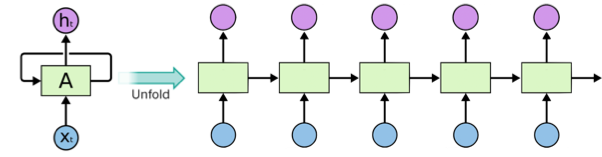

In [19]:
idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell

# Note: x_one_hot is changed to 1, 6, 5
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

y_data = [1, 0, 2, 3, 3, 4]    # ihello

In [22]:
# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.Tensor(x_one_hot))
labels = Variable(torch.LongTensor(y_data))

num_classes = 5
input_size = 5  # one-hot size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # Note: |ihello| == 6
num_layers = 1  # one-layer rnn

In [23]:
class RNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.rnn = nn.RNN(input_size=5, hidden_size=5, batch_first=True)
    def forward(self, x):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size) for batch_first=True
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Reshape input
        x.view(x.size(0), self.sequence_length, self.input_size)
        # Propagate input through RNN
        # Input: (batch, seq_len, input_size)
        # h_0: (num_layers * num_directions, batch, hidden_size)
        out, _ = self.rnn(x, h_0)
        return out.view(-1, num_classes)

In [24]:
# Instantiate RNN model
rnn = RNN(num_classes, input_size, hidden_size, num_layers)
print(rnn)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.1)

RNN(
  (rnn): RNN(5, 5, batch_first=True)
)


In [26]:
# Train the model
for epoch in range(100):
    outputs = rnn(inputs)
    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, idx = outputs.max(1)
    idx = idx.data.numpy()
    result_str = [idx2char[c] for c in idx.squeeze()]
    print("epoch: %d, loss: %1.3f" % (epoch + 1, loss.item()))
    print("Predicted string: ", ''.join(result_str))

print("Learning finished!")


epoch: 1, loss: 1.544
Predicted string:  lellll
epoch: 2, loss: 1.315
Predicted string:  lillll
epoch: 3, loss: 1.169
Predicted string:  lieloo
epoch: 4, loss: 1.041
Predicted string:  liello
epoch: 5, loss: 0.942
Predicted string:  lhello
epoch: 6, loss: 0.865
Predicted string:  ihello
epoch: 7, loss: 0.801
Predicted string:  ihelll
epoch: 8, loss: 0.752
Predicted string:  ihelll
epoch: 9, loss: 0.721
Predicted string:  ihelll
epoch: 10, loss: 0.693
Predicted string:  ihelll
epoch: 11, loss: 0.667
Predicted string:  ihelll
epoch: 12, loss: 0.648
Predicted string:  ihelll
epoch: 13, loss: 0.631
Predicted string:  ihelll
epoch: 14, loss: 0.617
Predicted string:  ihelll
epoch: 15, loss: 0.605
Predicted string:  ihelll
epoch: 16, loss: 0.595
Predicted string:  ihelll
epoch: 17, loss: 0.588
Predicted string:  ihelll
epoch: 18, loss: 0.582
Predicted string:  ihelll
epoch: 19, loss: 0.574
Predicted string:  ihelll
epoch: 20, loss: 0.568
Predicted string:  ihelll
epoch: 21, loss: 0.564
Predic

## RNN with Embeddings

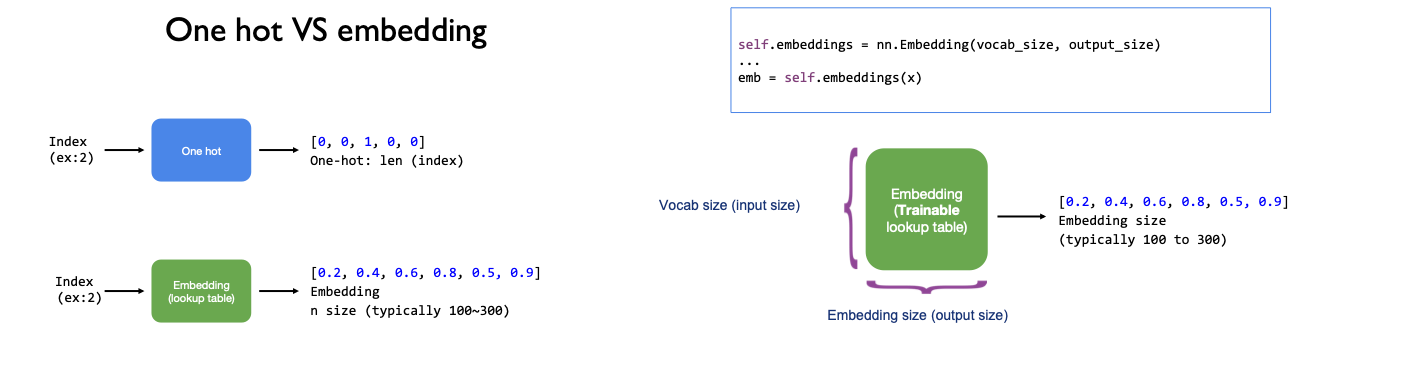

In [28]:
# Lab 12 RNN
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(777)  # reproducibility

idx2char = ['h', 'i', 'e', 'l', 'o']

# Teach hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
y_data = [1, 0, 2, 3, 3, 4]    # ihello

# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.LongTensor(x_data))
labels = Variable(torch.LongTensor(y_data))

In [29]:
num_classes = 5
input_size = 5
# Note: add embedding size
embedding_size = 10  # embedding size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # |ihello| == 6
num_layers = 1  # one-layer rnn

In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size) 
        # input_size: 有几个不同的词汇；embedding_size: 把这些词汇embed到几个维度的空间里
        self.rnn = nn.RNN(input_size=embedding_size,
                          hidden_size=5, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        h_0 = Variable(torch.zeros(
            num_layers, x.size(0), hidden_size))

        emb = self.embedding(x)
        emb = emb.view(batch_size, sequence_length, -1)

        # Propagate embedding through RNN
        # Input: (batch, seq_len, embedding_size)
        # h_0: (num_layers * num_directions, batch, hidden_size)
        out, _ = self.rnn(emb, h_0)
        return self.fc(out.view(-1, num_classes))

In [31]:
# Instantiate RNN model
model = Model()
print(model)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Model(
  (embedding): Embedding(5, 10)
  (rnn): RNN(10, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=5, bias=True)
)


In [33]:
# Train the model
for epoch in range(50):
    outputs = model(inputs)
    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, idx = outputs.max(1)
    idx = idx.data.numpy()
    result_str = [idx2char[c] for c in idx.squeeze()]
    print("epoch: %d, loss: %1.3f" % (epoch + 1, loss.item()))
    print("Predicted string: ", ''.join(result_str))

print("Learning finished!")


epoch: 1, loss: 0.007
Predicted string:  ihello
epoch: 2, loss: 0.007
Predicted string:  ihello
epoch: 3, loss: 0.007
Predicted string:  ihello
epoch: 4, loss: 0.006
Predicted string:  ihello
epoch: 5, loss: 0.006
Predicted string:  ihello
epoch: 6, loss: 0.006
Predicted string:  ihello
epoch: 7, loss: 0.006
Predicted string:  ihello
epoch: 8, loss: 0.006
Predicted string:  ihello
epoch: 9, loss: 0.006
Predicted string:  ihello
epoch: 10, loss: 0.006
Predicted string:  ihello
epoch: 11, loss: 0.006
Predicted string:  ihello
epoch: 12, loss: 0.006
Predicted string:  ihello
epoch: 13, loss: 0.006
Predicted string:  ihello
epoch: 14, loss: 0.006
Predicted string:  ihello
epoch: 15, loss: 0.005
Predicted string:  ihello
epoch: 16, loss: 0.005
Predicted string:  ihello
epoch: 17, loss: 0.005
Predicted string:  ihello
epoch: 18, loss: 0.005
Predicted string:  ihello
epoch: 19, loss: 0.005
Predicted string:  ihello
epoch: 20, loss: 0.006
Predicted string:  ihello
epoch: 21, loss: 0.034
Predic

## Under the hood: RNN

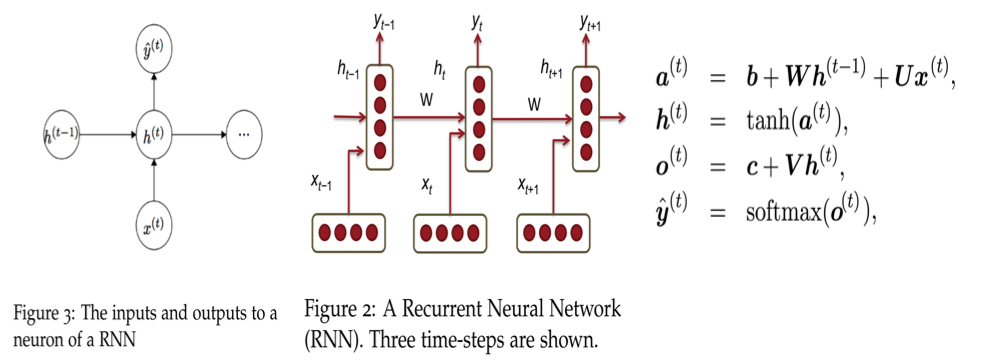

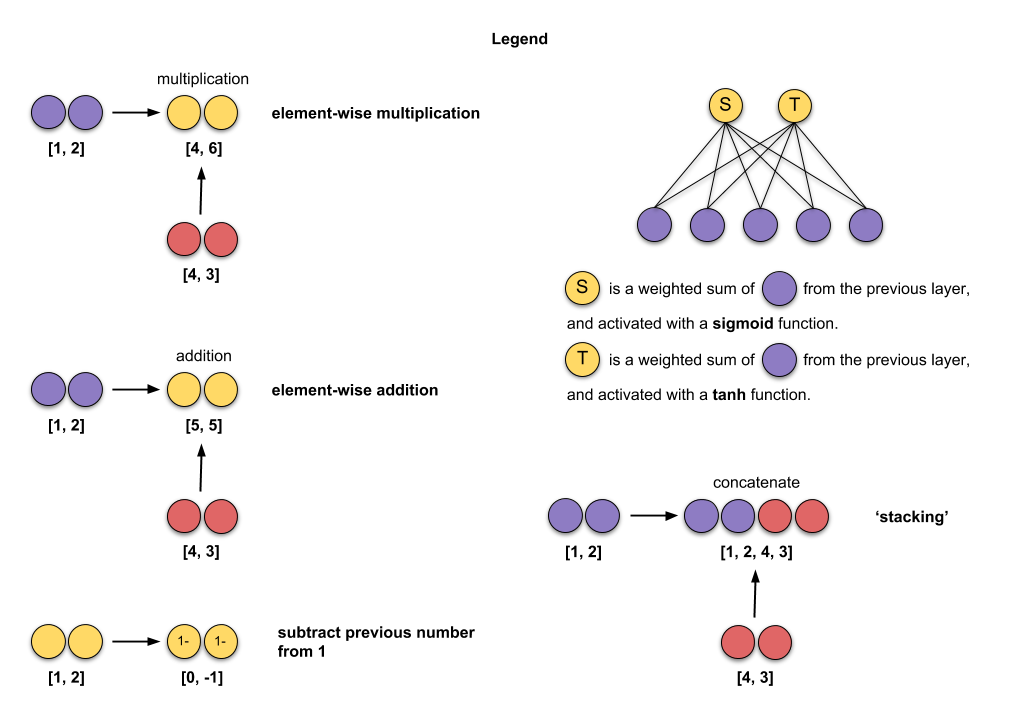

https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45

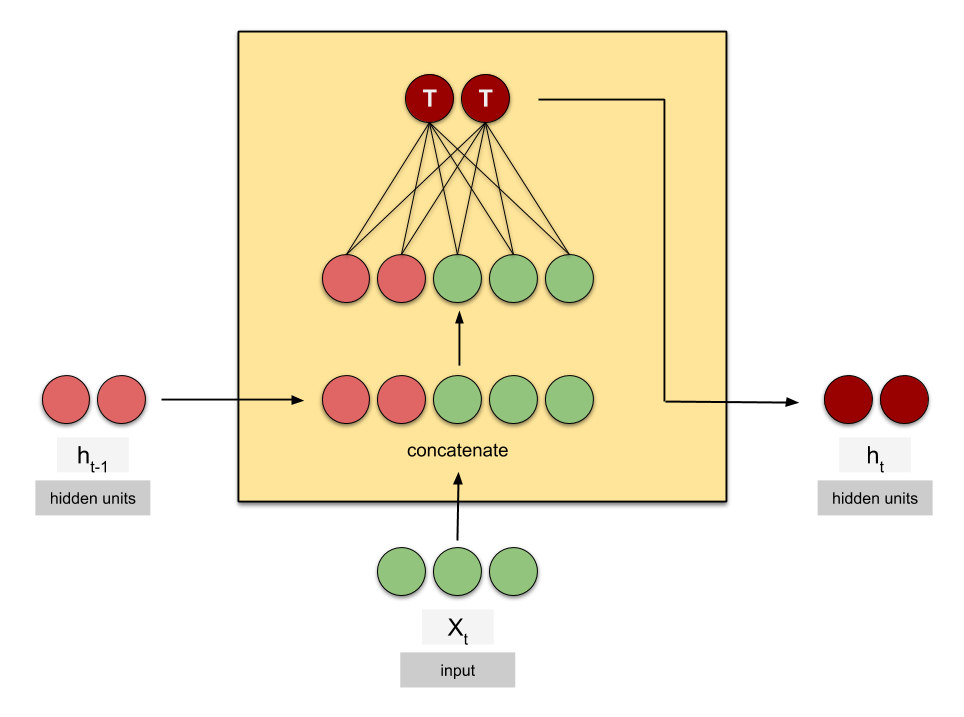


## Under the hood: LSTMs 

Long Short Term Memory networks 

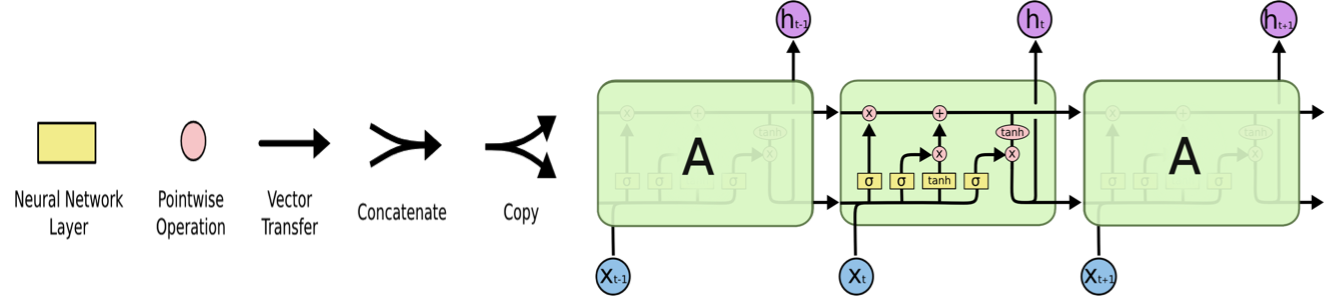

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

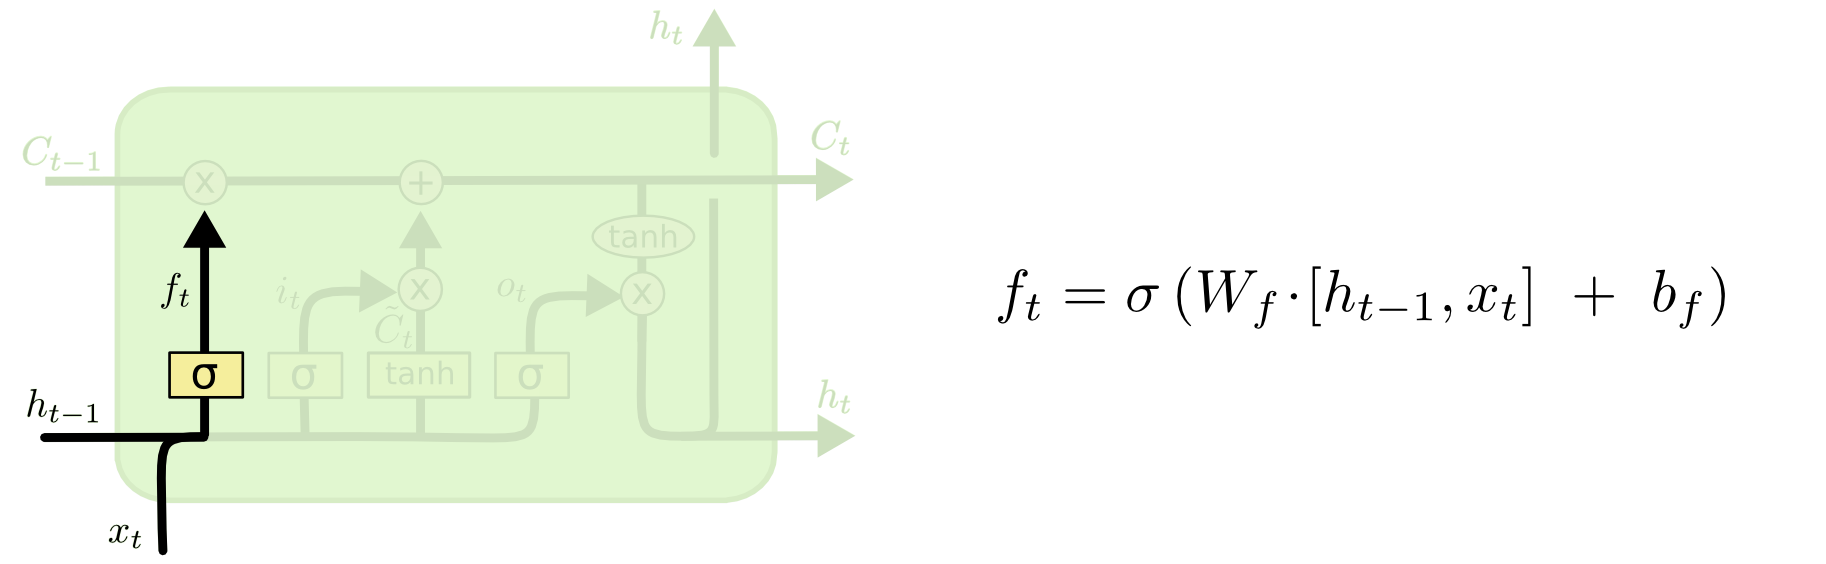

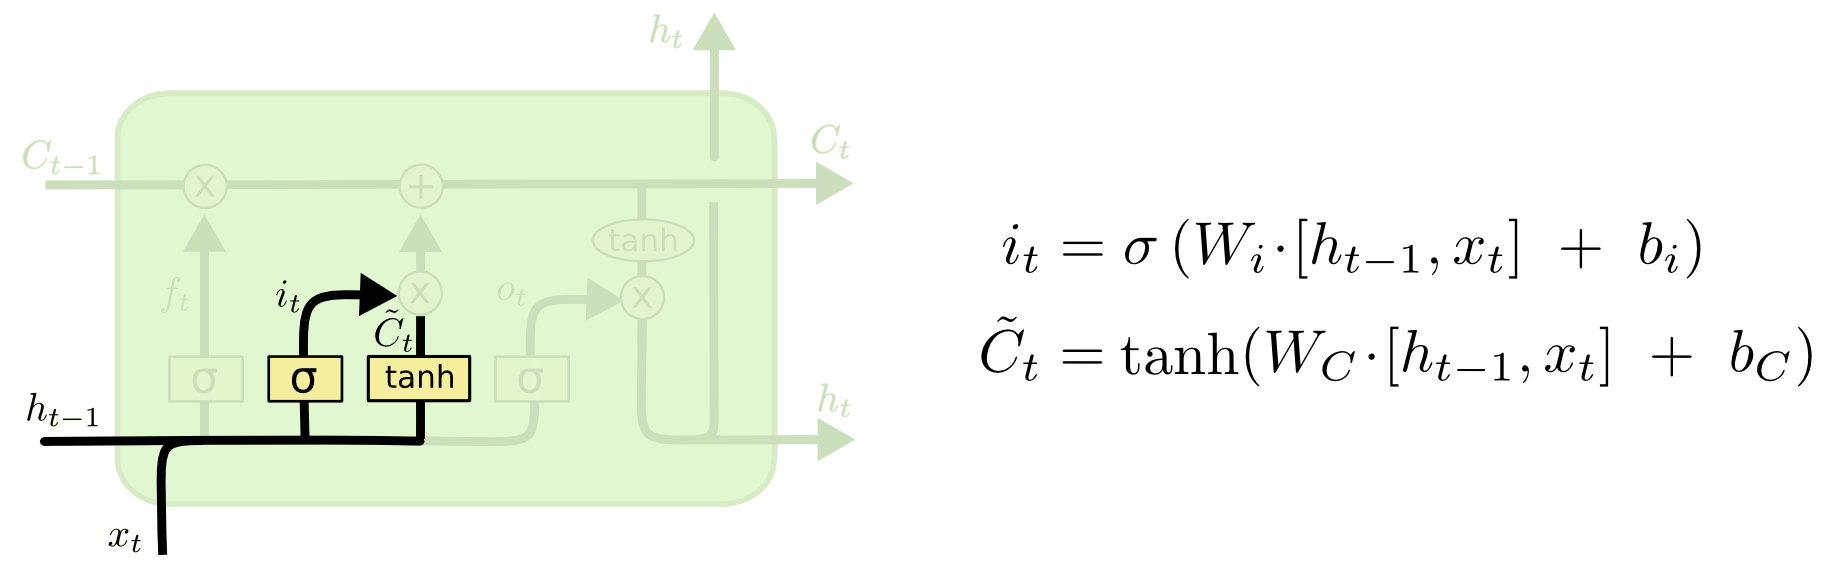

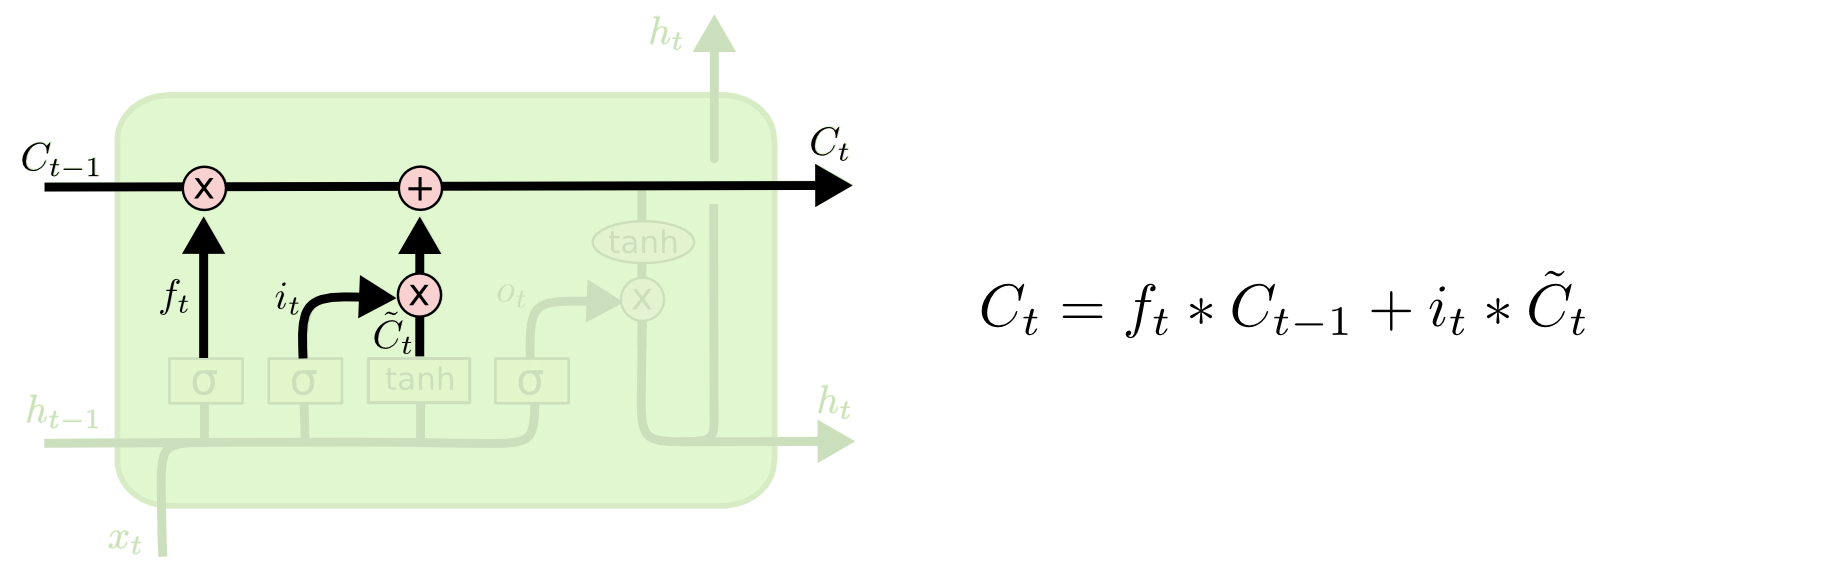

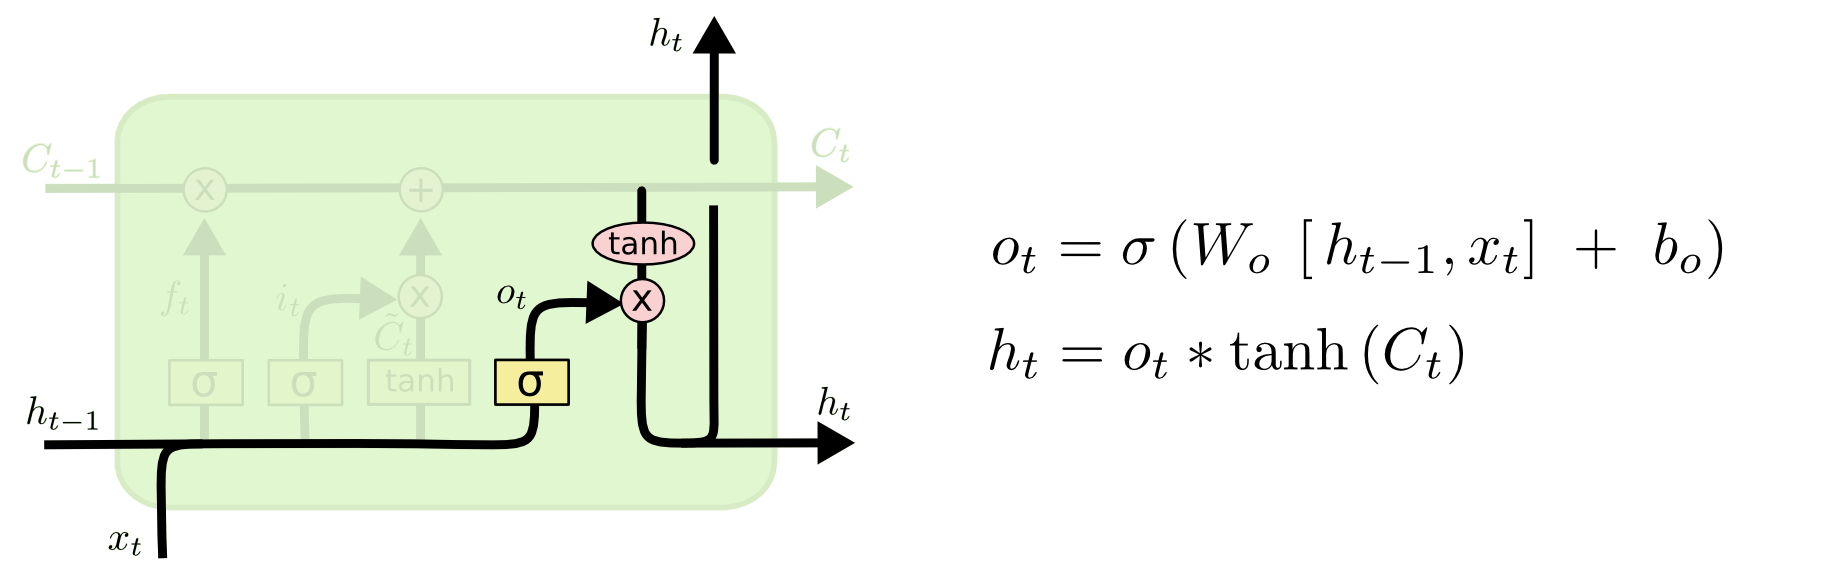

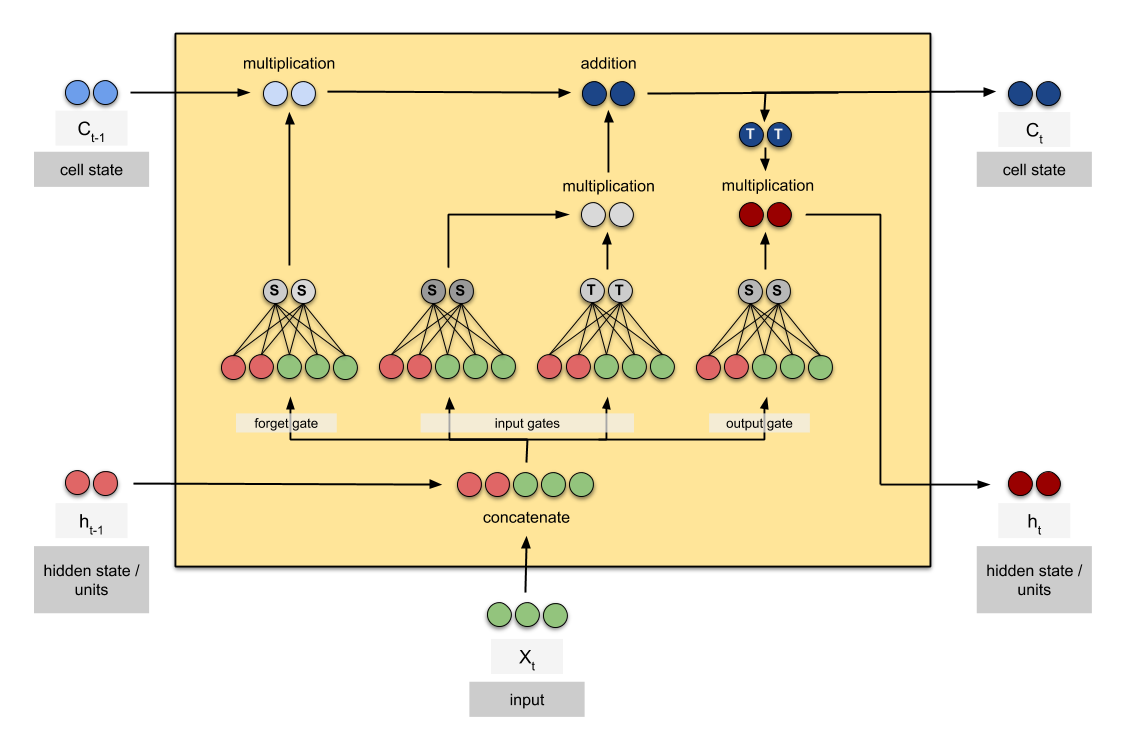

## Under the hood: GRU

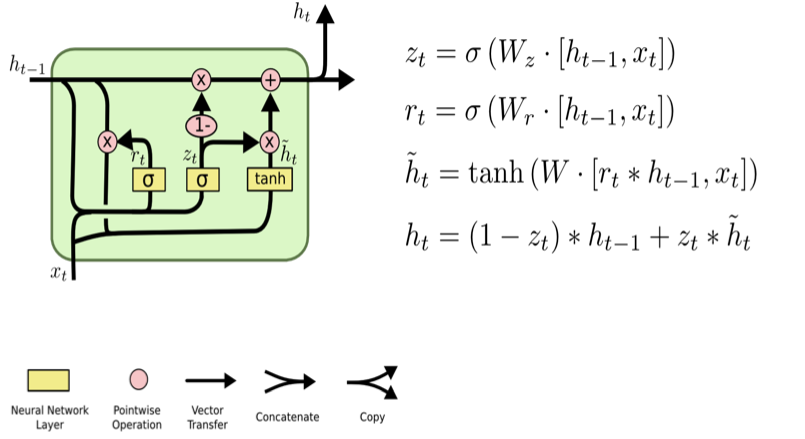

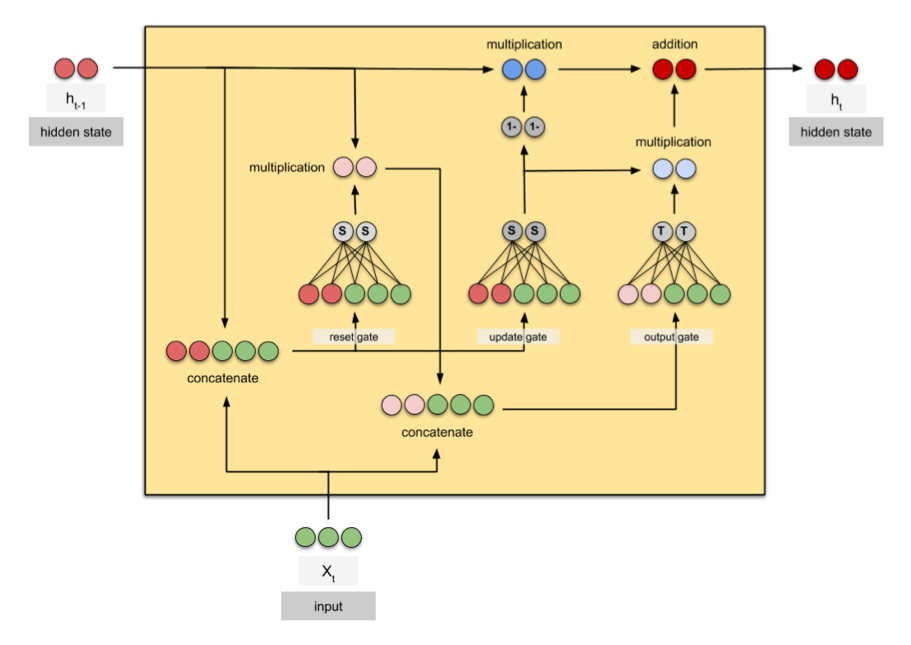

<div>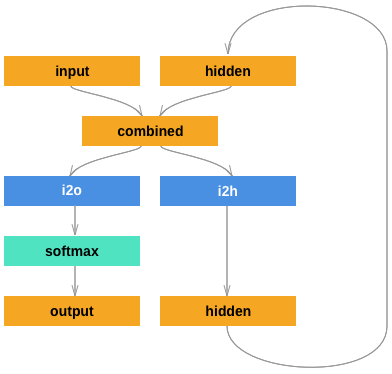</div>

**Practical PyTorch: Classifying Names with a Character-Level RNN**

We will train a basic character-level RNN to classify words. It reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to. 

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb



## Exercise: Sentiment analysis on movie reviews

The sentiment labels are:

```
0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive
```

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

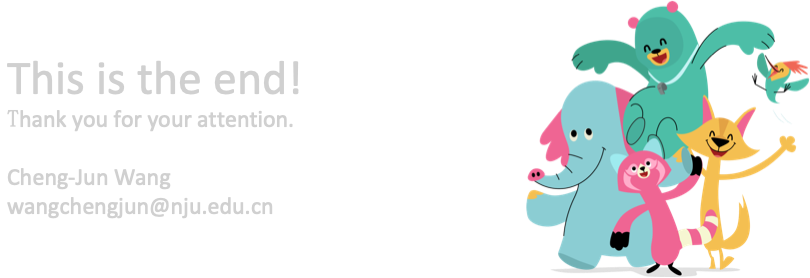